## Embedding CD14+ Monocytes scRNA-seq data into hyperbolic space ##

In [2]:
%cd ~/Desktop/University/Work\ Stuff/ding_group_dir_stu/scphere/
import numpy as np
import torch
from torch import nn
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scphere.util.util import read_mtx
from scphere.util.trainer import Trainer
from scphere.model.vae import SCPHERE
from scphere.util.plot import plot_trace
from example.script.plot_latents import plot_latents

/Users/carlosvasquez/Desktop/University/Work Stuff/ding_group_dir_stu/scphere


### Getting cell by gene data, and cell types

In [34]:
data_path = './example/data/'
save_path = './example/demo-out/wn_250epoch_monocytes'
# this latter portion in save_path represents the prefix for all names of the outputs

x = read_mtx(data_path + 'cd14_monocyte_erythroid.mtx')
x = x.transpose().todense()
cell_types = pd.read_csv(data_path + 'cd14_monocyte_erythroid_celltype.tsv', sep='\t', header=None).to_numpy()
# in the case that cell type is not available, you can set
#           cell_types = None

### Getting the batch data

In [35]:
# In this demo the cd14+ dataset has no batches, so we create a dummy batch vector:
# For this particular demo, since there's no existing batch vector, then this dummy one has to serve as an
# index tensor for the one_hot function, which is why we initialize it as a LongTensor. For other datasets
# where you have some batches, there is no need to initliaze it as so, a numpy array works too. 
batch = torch.tensor(np.zeros((x.shape[0],1))).long() * -1
n_batch = 1

### Building the model

In [61]:
model = SCPHERE(
    n_gene = x.shape[1], # if X is NxD, then n_gene = D
    n_batch = n_batch,
    batch_invariant = False,
    z_dim = 2, # 2d for visualization purposes
    latent_dist = 'wn', # hyperbolic space
    observation_dispersion = 'gene'
)
model.train()

-------- Built SCPHERE model --------


SCPHERE(
  (activation): ELU(alpha=1.0)
  (encoder): Sequential(
    (0): Linear(in_features=2001, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ELU(alpha=1.0)
    (5): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ELU(alpha=1.0)
    (8): BatchNorm1d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  )
  (z_mu_layer): Linear(in_features=32, out_features=2, bias=True)
  (z_sigma_square_layer): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)

### Training the model

In [62]:
trainer = Trainer(
    model = model,
    x = x,
    batch_id = batch,
    max_epoch = 250,
    mb_size = 128,
    learning_rate = 0.001
)
trainer.train()

Finished creating Optimizer!
0 / 4250 {'Log-likelihood': array(-1166.0214, dtype=float32), 'ELBO': array(1166.7983, dtype=float32), 'KL': array(0.7769968, dtype=float32)}
50 / 4250 {'Log-likelihood': array(-805.28467, dtype=float32), 'ELBO': array(808.3911, dtype=float32), 'KL': array(3.1064365, dtype=float32)}
100 / 4250 {'Log-likelihood': array(-693.0617, dtype=float32), 'ELBO': array(696.1289, dtype=float32), 'KL': array(3.0672085, dtype=float32)}
150 / 4250 {'Log-likelihood': array(-542.4543, dtype=float32), 'ELBO': array(545.4785, dtype=float32), 'KL': array(3.0242538, dtype=float32)}
200 / 4250 {'Log-likelihood': array(-452.1729, dtype=float32), 'ELBO': array(455.14853, dtype=float32), 'KL': array(2.9756064, dtype=float32)}
250 / 4250 {'Log-likelihood': array(-439.11224, dtype=float32), 'ELBO': array(441.8103, dtype=float32), 'KL': array(2.6980543, dtype=float32)}
300 / 4250 {'Log-likelihood': array(-425.88727, dtype=float32), 'ELBO': array(428.51926, dtype=float32), 'KL': array(

### Saving the model, plotting the KL-divergence & log-likelihood, and plotting the embeddings

In [63]:
torch.save(model.state_dict(), save_path + '_model.pth')

### Plotting KL-divergence & log-likelihood

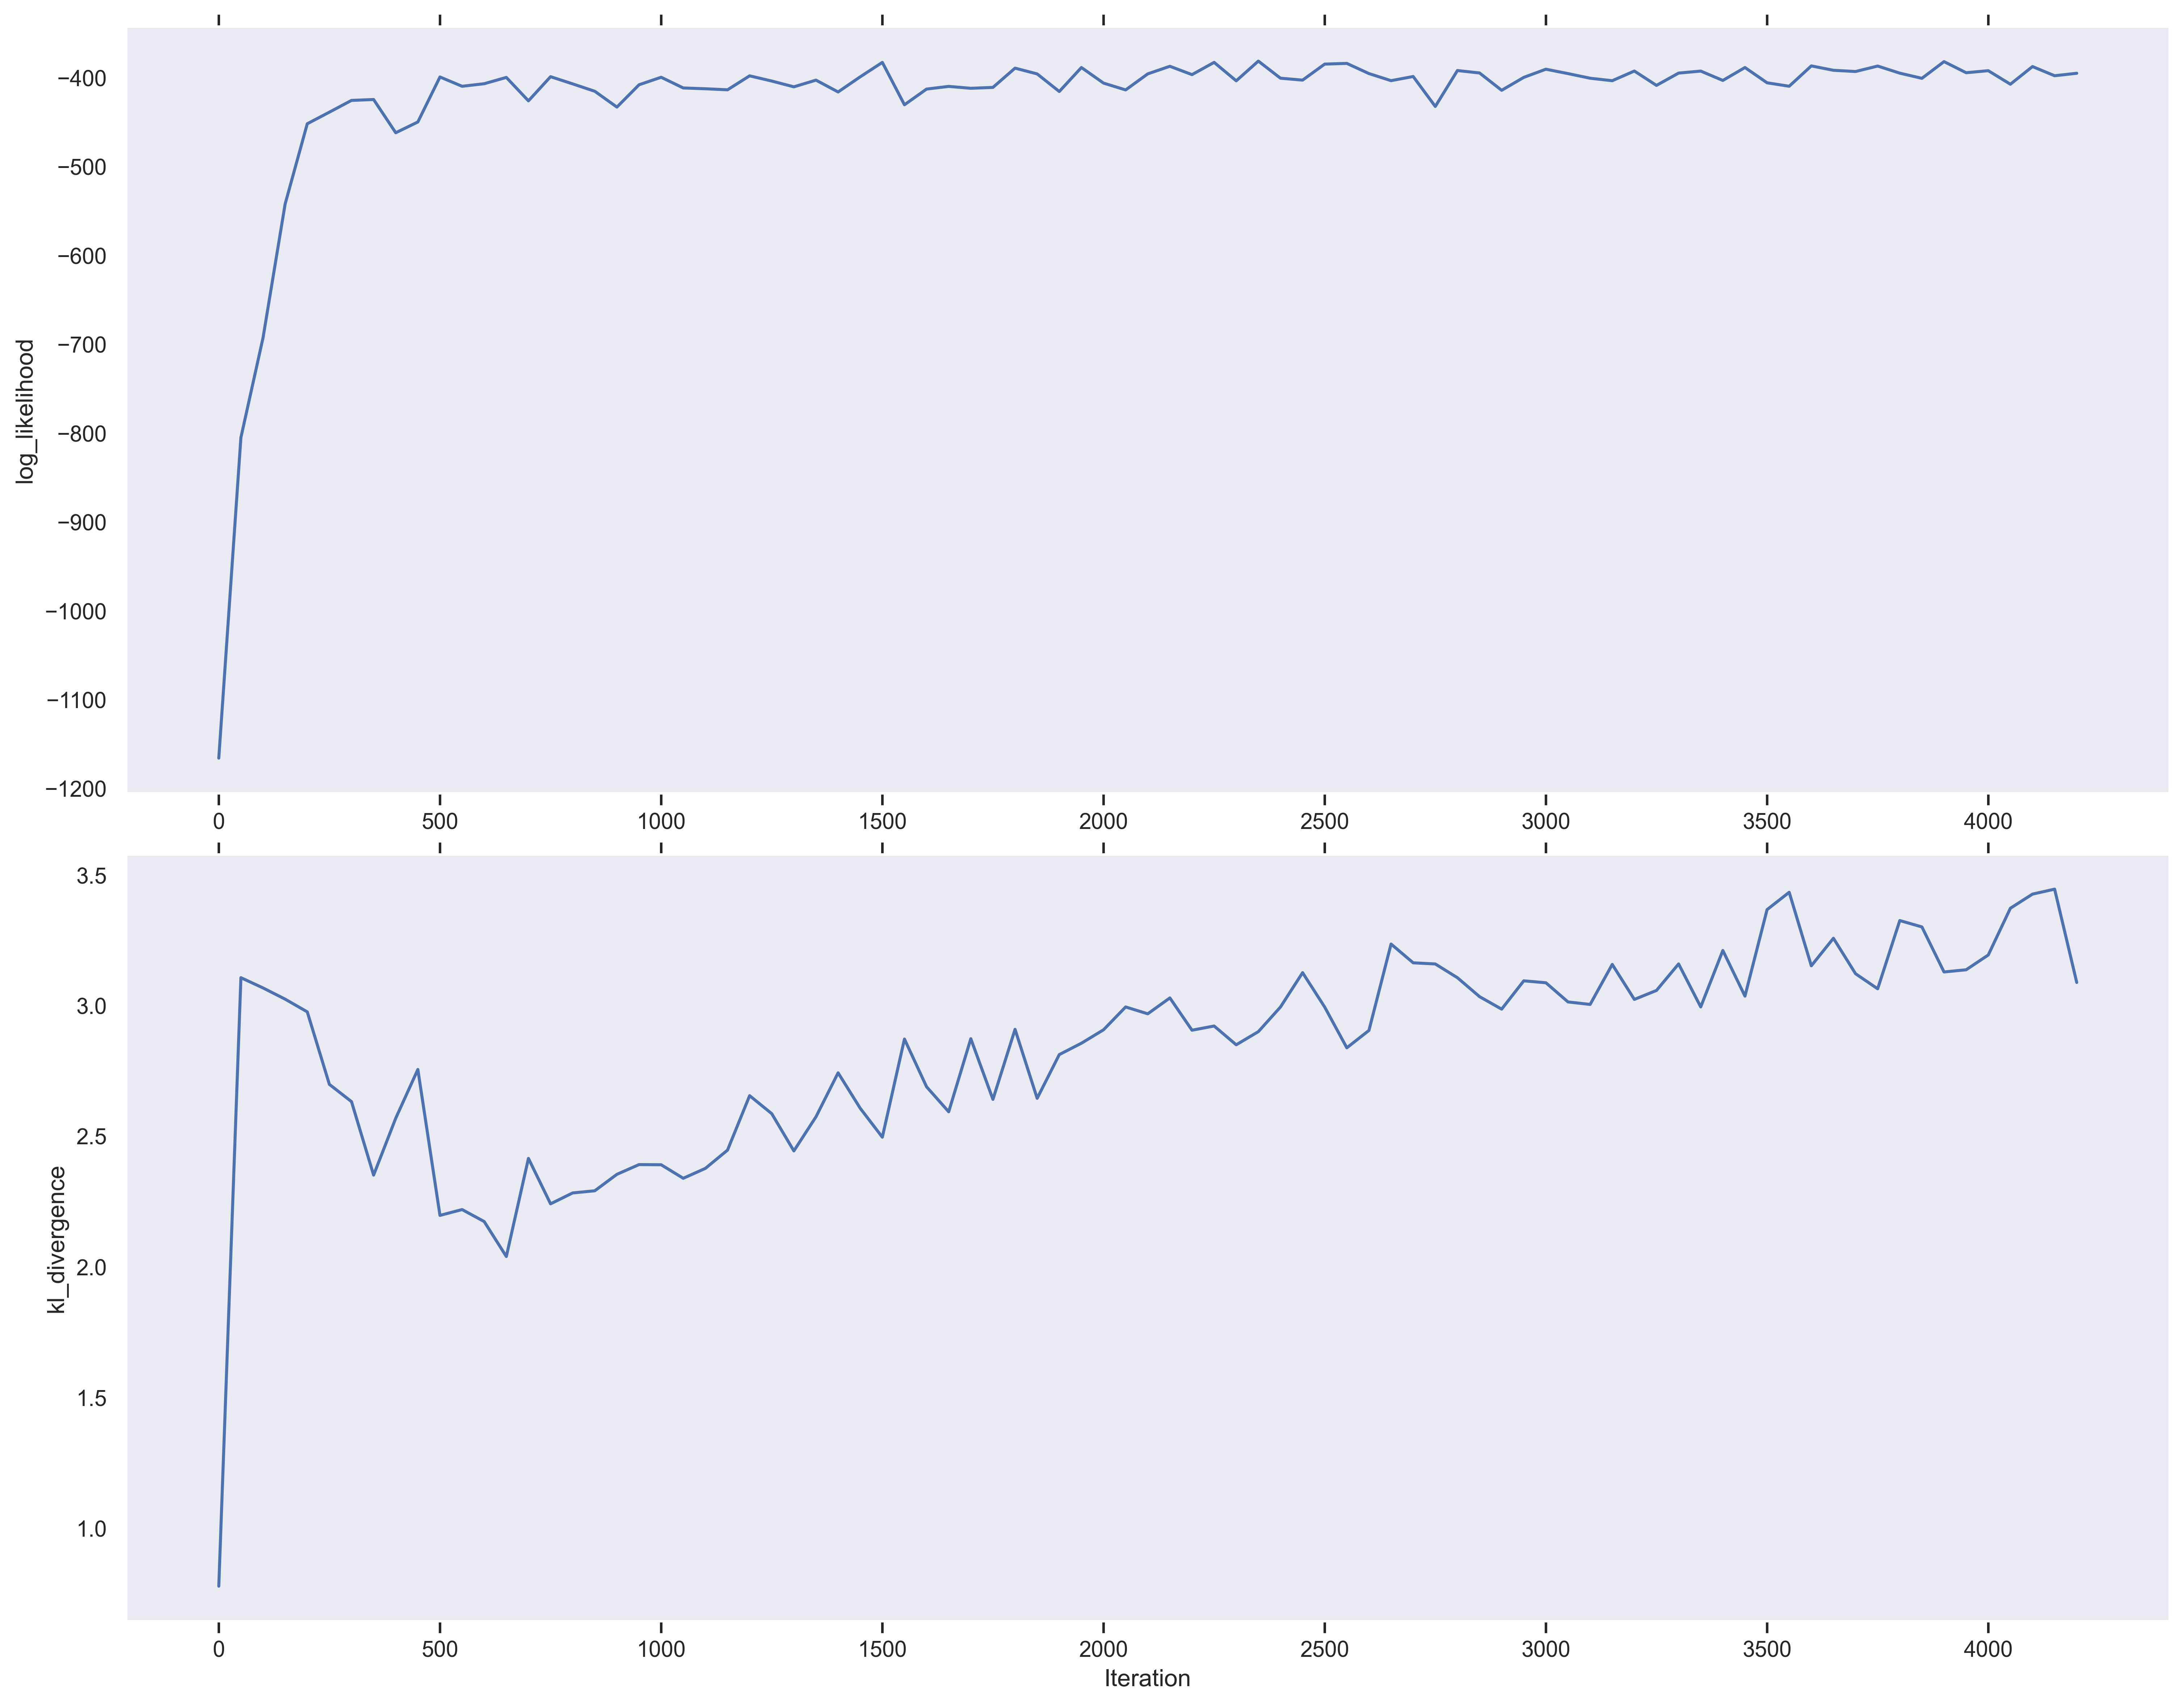

In [65]:
plot_trace([np.arange(len(trainer.status['kl_divergence']))*50] * 2,
            [trainer.status['log_likelihood'], trainer.status['kl_divergence']],
            ['log_likelihood', 'kl_divergence'])
plt.savefig(save_path + '_train.png')

### Embedding cells into hyperbolic space and plotting embeddings

/Users/carlosvasquez/anaconda3/envs/scphere/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


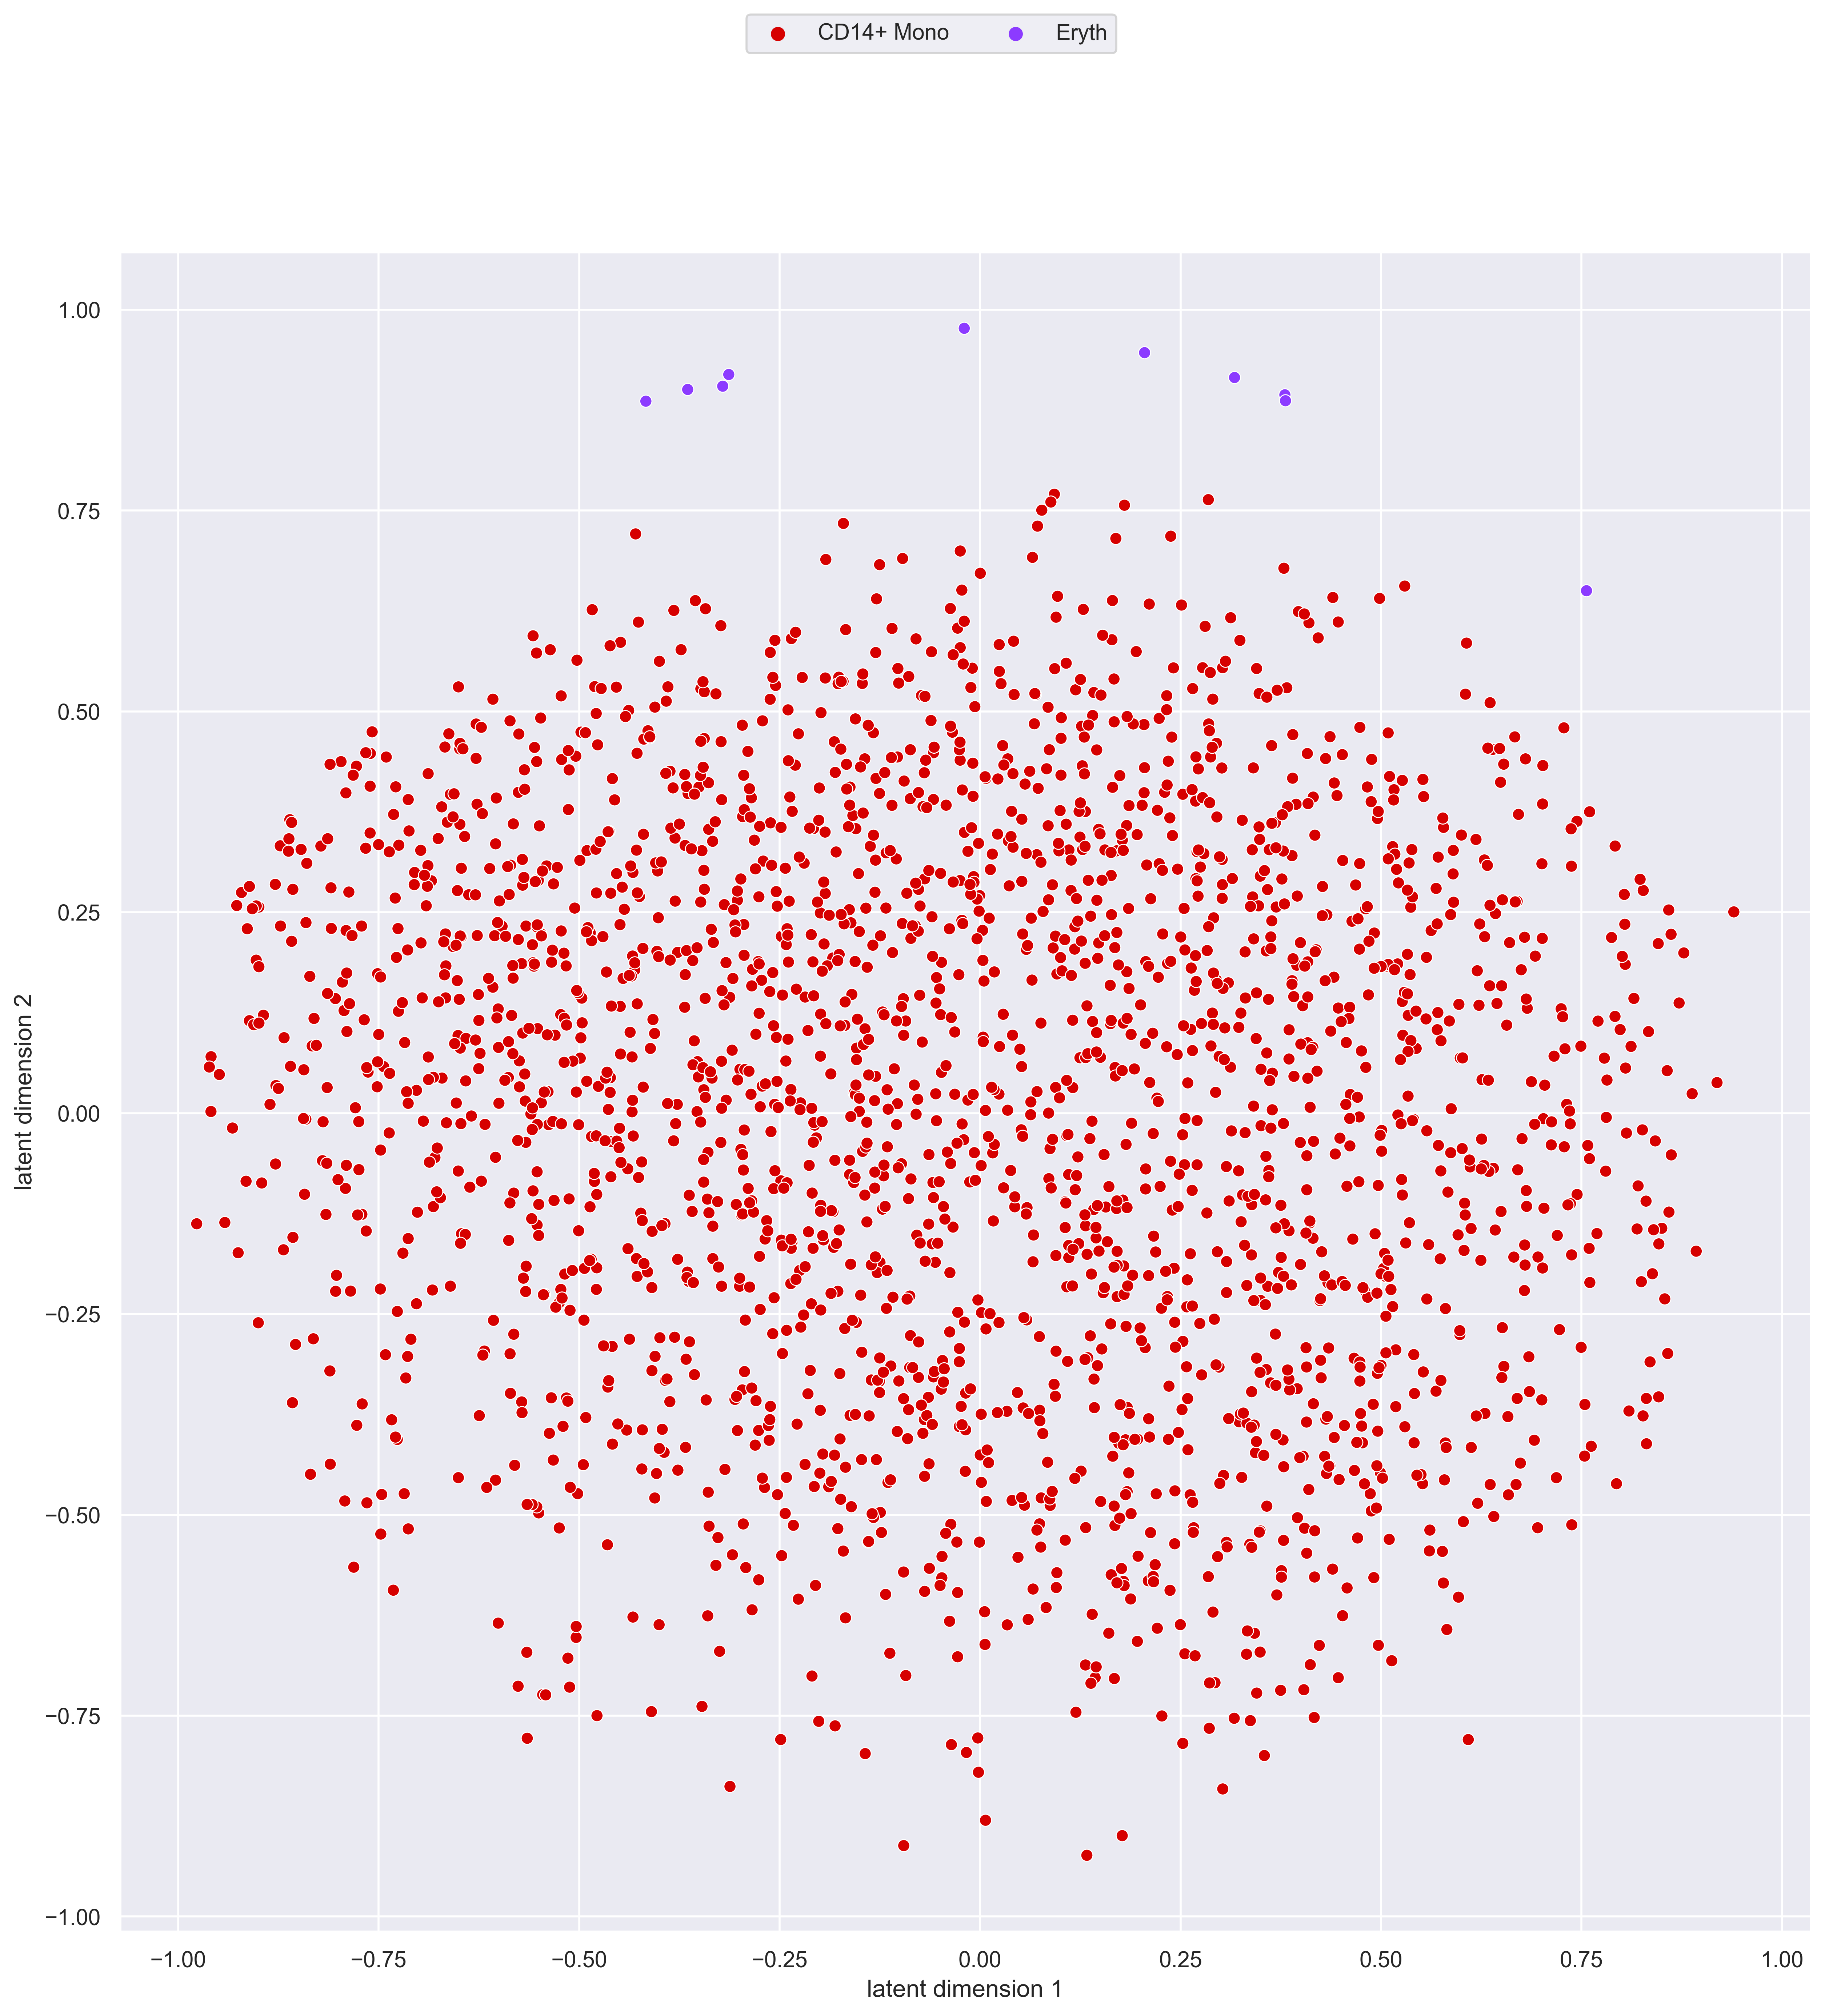

In [66]:
model.eval()
model.forward(torch.tensor(x), torch.tensor(batch))
z_mu = model.z_mu.detach().numpy()
np.savetxt(save_path + '_latent.tsv', z_mu)

plot_latents(save_path, embeddings=z_mu, cell_types=cell_types, latent_dist=model.latent_dist)